In [2]:
import os
import csv  
import pdb
from multiprocessing import Pool

import numpy as np
import pandas as pd
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
from scipy.linalg import cho_factor, cho_solve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import celerite
import radvel

import rvsearch

import occur

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [3]:
sysprops = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [4]:
specmatch = pd.read_csv('~/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [5]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [6]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [7]:
hostnames = list(set(planets.hostname))

In [8]:
len(hostnames)

116

In [9]:
print(hostnames)

['192263', '82943', '175541', '190360', '187123', '80606', '95128', '120136', '186427', '16141', '10697', '218566', '156279', 'hip57050', '115617', '3651', '90156', 'gl317', 'hip74995', '130322', '222582', '68988', '72659', 'bd-103166', '169830', '74156', '1326', '147379a', '209458', '170469', '33636', '38529', '117176', '126614', '40979', '195019', '99492', 'hip57087', '181234', 'hip22627', '28185', '183263', '42618', '92788', '128311', '168443', '143761', 'hip83043', '114783', '168746', '50554', '188015', '164922', '104067', '97101', '75732', '134987', '46375', '154345', '167042', '219134', '177830', '26161', '4203', '217014', '97658', '120066', '95735', '285968', '210277', '145675', '24040', '52265', '9826', '108874', '45350', '7924', '87883', '4208', '156668', '136925', '3765', '32963', '141004', '49674', '11964a', '37124', '178911b', '216520', '34445', '213472', '13931', '114729', 'hip109388', '141399', '107148', '217107', '31253', '117207', '1461', '66428', '145934', '22049', 'gl

In [9]:
with open('legacy_planets.txt', 'w') as f:
    f.writelines("%s\n" % hostname for hostname in hostnames)

## Examine mass and period distributions.

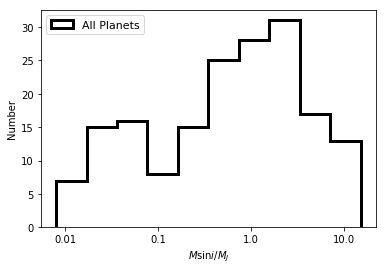

In [10]:
fig, ax = plt.subplots()
ax.hist(np.log10(planets.query('mass < 15')['mass']), 
        bins=10, density=False, histtype='step', range=(np.log10(0.008), np.log10(15)),
        lw=3, color='black', alpha=1, label='All Planets')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i/M_J$', 
          ylabel='Number')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/mass_histogram_all.png', dpi=500, bbox_inches='tight')

In [11]:
masses_close = planets.query('axis < 1 and mass < 15')
masses_mid   = planets.query('axis >= 1 and axis < 3 and mass < 15')
masses_far   = planets.query('axis >= 3 and mass < 15')

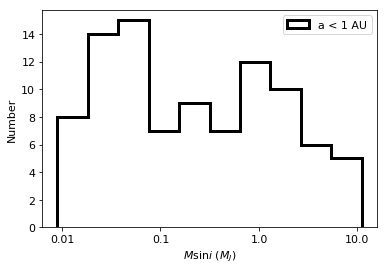

In [12]:
mclose = masses_close.mass
#thresh_close = np.log10(0.075) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mclose), bins=10, density=False, histtype='step',
        lw=3, color='black', alpha=1, label='a < 1 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=1)

fig.savefig('plots/close_histogram.png', dpi=500, bbox_inches='tight')

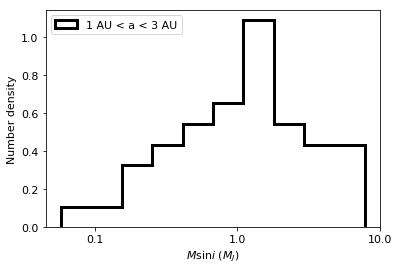

In [13]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mmid), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/mid_histogram.png', dpi=500, bbox_inches='tight')

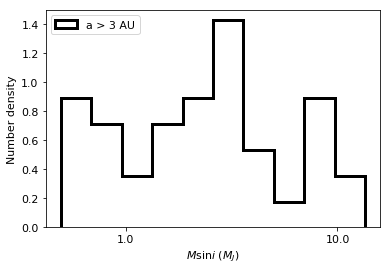

In [14]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mfar), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a > 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/far_histogram.png', dpi=500, bbox_inches='tight')

## How many stars that host small planets have linear or parabolic trends?

In [15]:
trend_names = np.unique(trends.hostname)
small_names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)

In [16]:
[name for name in trend_names if name in small_names]

['156668', '45184']

### The 156668 trend is modeling out an activity alias, and the 45184 trend might be activity itself.

## Sketch code to stack injections on cadence, with msini & a.

In [10]:
def save_completeness(listf, outf, stellarf, recdir):
    names = pd.read_csv(listf)
    stars = pd.read_csv(stellarf)
    
    all_recoveries = pd.DataFrame()
    
    for name in names['name']:
        recoveries = pd.read_csv(recdir + '/' + name + '/recoveries.csv')
        mstar = float(stars.query('name == @name')['mass_c'])
        rstar = float(stars.query('name == @name')['radius_c'])
        teff  = float(stars.query('name == @name')['teff_c'])
        
        recoveries['inj_msini'] = radvel.utils.Msini(recoveries['inj_k'],
                                                     recoveries['inj_period'],
                                                     mstar, recoveries['inj_e'],
                                                     Msini_units='jupiter')
        recoveries['rec_msini'] = radvel.utils.Msini(recoveries['rec_k'],
                                                     recoveries['rec_period'],
                                                     mstar, recoveries['rec_e'],
                                                     Msini_units='jupiter')
        recoveries['inj_au'] = radvel.utils.semi_major_axis(recoveries['inj_period'], mstar)
        recoveries['rec_au'] = radvel.utils.semi_major_axis(recoveries['rec_period'], mstar)   
        recoveries['inj_insol'] = rvsearch.utils.insolate(teff, rstar, recoveries['inj_au'])
        recoveries['rec_insol'] = rvsearch.utils.insolate(teff, rstar, recoveries['rec_au']) 
        
        all_recoveries = all_recoveries.append(recoveries).reset_index(drop=True)
        
    all_recoveries.to_csv(outf)

## Create class for evaluating a completeness grid across injections and recoveries. Clone of BJ's code in RVSearch, except passing in msini and axis as inputs, rather than computing with a single stellar mass.

In [11]:
class Completeness(object):
    """Object to handle a suite of injection/recovery tests

    Args:
        recoveries (DataFrame): DataFrame of injection/recovery tests from Injections class
        xcol (string): (optional) column name for independent variable. Completeness grids and
            interpolator will work in these axes
        ycol (string): (optional) column name for dependent variable. Completeness grids and
            interpolator will work in these axes

    """   
    def __init__(self, recoveries, xcol='inj_au', ycol='inj_msini'):

        self.recoveries = recoveries
        
        self.xcol = xcol
        self.ycol = ycol

        self.grid = None
        self.interpolator = None    

    def completeness_grid(self, xlim, ylim, resolution=20, xlogwin=0.5, ylogwin=0.5):

        xgrid = np.logspace(np.log10(xlim[0]),
                            np.log10(xlim[1]),
                            resolution)
        ygrid = np.logspace(np.log10(ylim[0]),
                            np.log10(ylim[1]),
                            resolution)

        xinj = self.recoveries[self.xcol]
        yinj = self.recoveries[self.ycol]

        good = self.recoveries['recovered']
        
        z = np.zeros((len(ygrid), len(xgrid)))
        last = 0
        for i,x in enumerate(xgrid):
            for j,y in enumerate(ygrid):
                xlow  = 10**(np.log10(x) - xlogwin/2)
                xhigh = 10**(np.log10(x) + xlogwin/2)
                ylow  = 10**(np.log10(y) - ylogwin/2)
                yhigh = 10**(np.log10(y) + ylogwin/2)

                xbox = yinj[np.where((xinj <= xhigh) & (xinj >= xlow))[0]]
                if len(xbox) == 0 or y > max(xbox) or y < min(xbox):
                    z[j, i] = np.nan
                    continue

                boxall = np.where((xinj <= xhigh) & (xinj >= xlow) &
                                  (yinj <= yhigh) & (yinj >= ylow))[0]
                boxgood = np.where((xinj[good] <= xhigh) &
                                   (xinj[good] >= xlow) & (yinj[good] <= yhigh) &
                                   (yinj[good] >= ylow))[0]

                if len(boxall) > 10:
                    z[j, i] = float(len(boxgood))/len(boxall)
                    last = float(len(boxgood))/len(boxall)
                else:
                    z[j, i] = np.nan

        self.grid = (xgrid, ygrid, z)
    
    def interpolate(self, x, y, refresh=False):

        if self.interpolator is None or refresh:
            assert self.grid is not None, "Must run Completeness.completeness_grid()."
            zi = self.grid[2].T
            self.interpolator = RegularGridInterpolator((self.grid[0], self.grid[1]), zi, 
                                                        bounds_error=False, fill_value=0.001) # Maybe don't set fill
        
        return self.interpolator(np.array([np.atleast_1d(x), np.atleast_1d(y)]).T)

## Sketch DFM occurrence likelihood, first with broken power law, then nonparametric.

In [12]:
def occbroken(a, theta):
    return theta[0]*(a**theta[1])*(1 - np.exp(-(a/theta[2])**theta[3]))

def nll(theta, x, y, yerr):
    return 0.5*np.sum((y-occbroken(x, theta))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

def fit_broken(x, y, yerr, C_init=80, beta_init=-0.2, a0_init=0.8, gamma_init=2): 
    fit = op.minimize(nll, [C_init, beta_init, a0_init, gamma_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x
giants = planets.query('mass >= 0.1')
num = np.histogram(np.log(giants.axis), bins=9, range=np.log([0.1,30]), density=False)
yerr = 0.5*np.ones(9)
fit = fit_broken(np.exp(num[1][:-1]), num[0], yerr)

In [13]:
class BrokenPowerLaw(object):
    """Do hierarchical Bayesian sampling of occurrence posteriors, based on DFM et al. 2014.
    Args:
        pop (pandas DataFrame): dataframe of planet parameter chains

    """
    def __init__(self, pop, completeness, lna_res=50, edges=np.array([[0.1, 30], [30, 6000]]), 
                 chainname='powerlaw_chains.csv'):
        # TO-DO: Replace single-param planets with paths to posteriors.
        self.pop          = pop 
        self.completeness = completeness 
        self.completeness.completeness_grid([0.01, 40], [3, 7000])
        # Fill in completeness nans.
        self.completeness.grid[2][np.isnan(self.completeness.grid[2])] = 1.  
                
        axis  = []
        msini = []
        self.planetnames = np.unique([x[:-2] + x[-1] for x in pop.columns]) 
        self.starnames   = np.unique([x[:-1] for x in self.planetnames])
        self.nplanets    = len(self.planetnames)
        self.nsamples    = len(self.pop)
        self.nstars      = len(self.starnames)
        
        medians = pop.median() 
        for name in self.planetnames:
            axis.append(medians[[name[:-1] + 'a' + name[-1]]][0])
            msini.append(medians[[name[:-1] + 'M' + name[-1]]][0])            
        self.pop_med = pd.DataFrame.from_dict({'axis':axis, 'msini':msini})
        
        self.chainname = chainname
        
        # Pre-compute integrated completeness over lna_res-many bins.
        self.lna_res = int(lna_res)
        self.edges = edges
        self.Qints = np.zeros(self.lna_res)
        self.lnawidth = (np.log(self.edges[0][1]) - np.log(self.edges[0][0]))/self.lna_res
        self.lnmwidth = (np.log(self.edges[1][1]) - np.log(self.edges[1][0]))/5.
        
        self.lna_centers = np.zeros(self.lna_res)
        self.lnm_centers = np.zeros(10)
        for i in np.arange(self.lna_res): 
            self.lna_centers[i] = np.log(self.edges[0][0]) + (i + 0.5)*self.lnawidth
        for j in np.arange(10): 
            self.lnm_centers[j] = np.log(self.edges[1][0]) + (j + 0.5)*self.lnmwidth 
        
        for i in np.arange(self.lna_res): 
            for j in np.arange(10): 
                self.Qints[i] += (self.lnawidth*self.lnmwidth) * \
                                  self.completeness.interpolate(np.exp(self.lna_centers[i]), 
                                                                np.exp(self.lnm_centers[j]))
        self.Qints /= (np.log(self.edges[1][1]) - np.log(self.edges[1][0])) # Necessary? Maybe can streamline DaDm.
        
    def max_like(self):
        # FIGURE THIS OUT? OR LEAVE AS DECENT GUESS.
        C_0 = 80
        beta_0 = -0.2
        a0_0 = 0.8
        gamma_0 = 2. 
        self.mlvalues = np.array([C_0, beta_0, a0_0, gamma_0])
        
    def occurrence(self, axis, theta):
        broken = np.atleast_1d(theta[0]*axis**theta[1]*(1 - np.exp(-(axis/theta[2])**theta[3])))
        broken[axis < 0.1] = 0.01
        broken[axis > 30.] = 0.01
        return broken 

    def lnlike(self, theta): 
        sums = []
        for planet in self.planetnames:
            probs = []
            sample_a = np.array(self.pop[planet[:-2] + '_a' + planet[-1]])
            sample_M = np.array(self.pop[planet[:-2] + '_M' + planet[-1]])
            probs = self.completeness.interpolate(sample_a, sample_M) * \
                                  self.occurrence(sample_a, theta)
            sums.append(np.sum(probs)) 
        
        nexpect = 0
        for i in np.arange(self.lna_res):
            nexpect += self.Qints[i]*self.occurrence(np.exp(self.lna_centers[i]), theta)  
             
        ll = -nexpect + np.sum(np.log(np.array(sums)/self.nsamples))
        if not np.isfinite(ll):
            return -np.inf
        return ll
    
    def lnprior(self, theta):
        if theta[0] <= 0 or theta[0] > 1600 or theta[1] > 3 or theta[1] < -6 or \
           theta[2] < 0.1 or theta[2] > 12 or theta[3] > 8 or theta[3] <= 0.1:
            return -np.inf
        return 0
    
    def lnpost(self, theta):
        return self.lnlike(theta) + self.lnprior(theta)
    
    def sample(self, parallel=False, save=True):
        nwalkers = 30
        ndim = 4
        pos = np.array([np.abs(self.mlvalues + 0.01*np.random.randn(ndim)) \
                                           for i in np.arange(nwalkers)])
        if parallel:
            with Pool(8) as pool:
                self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost, pool=pool)
                self.sampler.run_mcmc(pos, 1000, progress=True)
                self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))
        else:
            self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost)
            self.sampler.run_mcmc(pos, 1000, progress=True)           
            self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))    
            
        if save:
            chaindb = pd.DataFrame() 
            chaindb['C'] = self.chains[:, 0]
            chaindb['beta'] = self.chains[:, 1]
            chaindb['a0'] = self.chains[:, 2]
            chaindb['gamma'] = self.chains[:, 3]
            chaindb.to_csv(self.chainname)           
    
    def run(self):
        self.max_like()
        self.sample()                       

In [14]:
class Hierarchy(object):
    """Do hierarchical Bayesian sampling of occurrence posteriors, based on DFM et al. 2014.
    Args:
        pop (pandas DataFrame): dataframe of planet parameter chains

    """
    def __init__(self, pop, completeness, res=4, bins=np.array([[[np.log(0.02), np.log(20)], 
                                                                 [np.log(2.), np.log(6000)]]]),
                                                                  chainname='occur_chains.csv'):
        # TO-DO: Replace single-param planets with paths to posteriors.
        self.pop          = pop # Replace pairs of m & a with chains
        self.completeness = completeness # Completeness grid, defined as class object below.
        self.completeness.completeness_grid([0.01, 40], [3, 7000])
        # Fill in completeness nans.
        self.completeness.grid[2][np.isnan(self.completeness.grid[2])] = 1. #0.99
        
        
        self.res = res # Resolution for logarithmic completeness integration.
        self.bins = bins # Logarithmic bins in msini/axis space.
        self.nbins = len(self.bins)
        self.lna_edges = np.unique(self.bins[:, 0])
        self.lnm_edges = np.unique(self.bins[:, 1])
        self.nabins = len(self.lna_edges) - 1
        self.nmbins = len(self.lnm_edges) - 1
        
        # Compute bin centers and widths.
        self.bin_widths  = np.diff(self.bins)
        self.bin_centers = np.mean(self.bins, axis=2)
        self.bin_areas   = self.bin_widths[:,0]*self.bin_widths[:,1]
        
        # Pre-compute integrated completeness for each bin.
        self.Qints = np.zeros(self.nbins)
        for n, binn in enumerate(self.bins):
            for i in np.arange(4): #self.res
                for j in np.arange(4):
                    lna_av = binn[0][0] + (0.25*i + 0.125)*(binn[0][1] - binn[0][0])
                    lnm_av = binn[1][0] + (0.25*j + 0.125)*(binn[1][1] - binn[1][0])     
                    self.Qints[n] += (self.bin_areas[n][0]/self.res**2) * \
                                      self.completeness.interpolate(np.exp(lna_av), 
                                                                    np.exp(lnm_av))
                
        axis  = []
        msini = []
        self.planetnames = np.unique([x[:-2] + x[-1] for x in pop.columns]) 
        self.starnames   = np.unique([x[:-1] for x in self.planetnames])
        self.nplanets    = len(self.planetnames)
        self.nsamples    = len(self.pop)
        self.nstars      = len(self.starnames)
        
        medians = pop.median() # Along chain axis, once using chains.
        for name in self.planetnames:
            axis.append(medians[[name[:-1] + 'a' + name[-1]]][0])
            msini.append(medians[[name[:-1] + 'M' + name[-1]]][0])            
        self.pop_med = pd.DataFrame.from_dict({'axis':axis, 'msini':msini})
        
        self.chainname = chainname
        
    def max_like(self):
        ### Approximate max-likelihood occurrence values, with which to seed MCMC.
        mlvalues = np.empty((0, 2))
        for n, binn in enumerate(self.bins):
            # Integrate completeness across each individual bin.
            a1 = np.exp(binn[0][0])
            a2 = np.exp(binn[0][1])
            M1 = np.exp(binn[1][0])
            M2 = np.exp(binn[1][1])
            planets = self.pop_med.query('axis >= @a1 and axis < @a2 and \
                                         msini >= @M1 and msini < @M2')
            nplanets = len(planets)
            ml  = nplanets/self.Qints[n]
            uml = ml/np.sqrt(nplanets)
            if not np.isfinite(ml):
                ml = 0.01 
            if not np.isfinite(uml):
                uml = 1.
            mlvalues = np.append(mlvalues, np.array([[ml, uml]]), axis=0) 
        mlvalues[np.isnan(mlvalues)] = 0.01
        mlvalues[mlvalues == 0] = 0.01
        self.mlvalues = mlvalues
        self.ceiling = np.amax(mlvalues)
        
    def occurrence(self, lna, lnm, theta):
        # Select appropriate bins, given lna & lnm.
        ia = np.atleast_1d(np.digitize(lna, self.lna_edges) - 1)
        im = np.atleast_1d(np.digitize(lnm, self.lnm_edges) - 1)
        iao = np.copy(ia)
        imo = np.copy(im)
        ia[ia < 0] = 0
        im[im < 0] = 0
        ia[ia > self.nabins - 1] = self.nabins - 1
        im[im > self.nmbins - 1] = self.nmbins - 1
        
        occur = theta[ia + im*self.nabins]
        # Return filler value for samples outside of the bin limits.
        occur[iao < 0] = 0.01 
        occur[imo < 0] = 0.01 
        occur[iao > self.nabins - 1] = 0.01 
        occur[imo > self.nmbins - 1] = 0.01 
        return occur    

    def lnlike(self, theta): 
        if np.any((theta <= 0) + (theta > 4*self.ceiling)):
            return -np.inf
        sums = []
        for planet in self.planetnames:
            probs = []
            sample_a = np.array(self.pop[planet[:-2] + '_a' + planet[-1]])
            sample_M = np.array(self.pop[planet[:-2] + '_M' + planet[-1]])
            probs = self.completeness.interpolate(sample_a, sample_M)*self.occurrence(
                                           np.log(sample_a), np.log(sample_M), theta)
            sums.append(np.sum(probs))
        
        # Integrate the observed occurrence over all bins. 
        nexpect = 0
        for i, binn in enumerate(self.bins):
            for j in np.arange(4): 
                for k in np.arange(4):
                    lna_av = binn[0][0] + (0.25*j + 0.125)*(binn[0][1] - binn[0][0])
                    lnm_av = binn[1][0] + (0.25*k + 0.125)*(binn[1][1] - binn[1][0])                    
                    nexpect += (self.bin_areas[i][0]/16)*self.completeness.interpolate(
                                                                        np.exp(lna_av), 
                                                                        np.exp(lnm_av))*self.occurrence(
                                                                        lna_av, lnm_av, theta)               
        ll = -nexpect + np.sum(np.log(np.array(sums)/self.nsamples))
        if not np.isfinite(ll):
            return -np.inf
        return ll
    
    def gpprior(self, theta, mu, l0, la, lm):
        ### Prior on occurrence. Gaussian process, for smoothly changing bin heights.
        if not 0 < mu < 4*self.ceiling:
            return -np.inf
        if not -2 < l0 < 6:
            return -np.inf
        if not -2 < la < 1:
            return -np.inf
        if not -2 < lm < 0:
            return -np.inf
        if np.any((theta <= 0) + (theta > 4*self.ceiling)): 
            return -np.inf

        # Compute Euclidean distance between bins, [∆i − ∆j]T Σ−1[∆i − ∆j]
        mini_inv_covar = np.array([[np.exp(la)**-1, 0], [0, np.exp(lm)**-1]])
        X              = np.matmul(self.bin_centers, mini_inv_covar)
        distance       = scipy.spatial.distance.cdist(X, X, 'sqeuclidean')
        
        K        = np.exp(l0)*np.exp(-0.5*distance)
        s, logdK = np.linalg.slogdet(K)
                
        y  = theta - mu
        F  = cho_factor(K)
        lp = -0.5*(logdK + np.dot(y, cho_solve(F, y)))
        
        if not np.isfinite(lp):
            return -np.inf
        return lp
    
    def lnpost(self, theta):
        return self.lnlike(theta) 
    
    def gppost(self, theta_gp):
        return self.lnlike(theta_gp[:-4]) + self.gpprior(theta_gp[:-4], 
                                                         theta_gp[-4], 
                                                         theta_gp[-3], 
                                                         theta_gp[-2], 
                                                         theta_gp[-1])
    
    def sample(self, gp=False, parallel=False, save=True):
        nwalkers = 4*self.nbins
        ndim = self.nbins 
        pos = np.array([np.abs(self.mlvalues[:, 0] + 0.01*np.random.randn(ndim)) \
                                                 for i in np.arange(nwalkers)]) + 0.01
        if gp:
            ndim += 4
            mu0 = np.mean(self.mlvalues[:, 0])
            l00 = 0
            la0 = 0
            lm0 = 0
            pos = np.append(pos, np.array([mu0, l00, la0, lm0]) + \
                                 np.array([0.05*np.random.randn(4) \
                                 for i in np.arange(nwalkers)]), axis=1)

        if parallel:
            with Pool(8) as pool:
                if gp:
                    self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.gppost, pool=pool)
                else:
                    self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost, pool=pool)
                self.sampler.run_mcmc(pos, 1000, progress=True)
                self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))
        else:
            if gp:
                self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.gppost)
            else:
                self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost)
            self.sampler.run_mcmc(pos, 1000, progress=True)           
            self.chains = self.sampler.chain[:, 100:, :].reshape((-1, ndim))    
            
        if save:
            chaindb = pd.DataFrame() 
            for n, binn in enumerate(self.bins):
                chaindb['gamma{}'.format(n)] = self.chains[:, n]
            if gp:
                chaindb['lmu)'] = self.chains[:, -4]
                chaindb['ll0)'] = self.chains[:, -3]
                chaindb['lla)'] = self.chains[:, -2]
                chaindb['llm)'] = self.chains[:, -1]
            chaindb.to_csv(self.chainname)           
    
    def run(self):
        self.max_like()
        self.sample()                       

In [15]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    dlna = (lna2 - lna1)/resa
    dlnM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*dlna, lna1 + (i+1)*dlna], 
                         [lnM1 + j*dlnM, lnM1 + (j+1)*dlnM]])
            
    return np.array(bins)

In [16]:
recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [18]:
samples_all = pd.read_csv('../legacy_samples/samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

columns_good = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [19]:
broken = BrokenPowerLaw(samples_all, completey_all)
broken.max_like()

In [28]:
broken.sample(parallel=True)

100%|██████████| 1000/1000 [21:56<00:00,  1.32s/it]


Text(0, 0.5, '$C$')

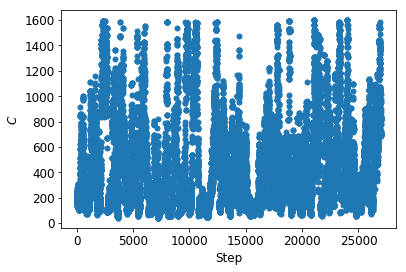

In [76]:
fig, ax = plt.subplots()
index = np.arange(len(broken.chains))
ax.scatter(index, broken.chains[:, 0])
ax.set_xlabel('Step')
ax.set_ylabel(r'$C$')
#ax.set_xlim([0, 20000])

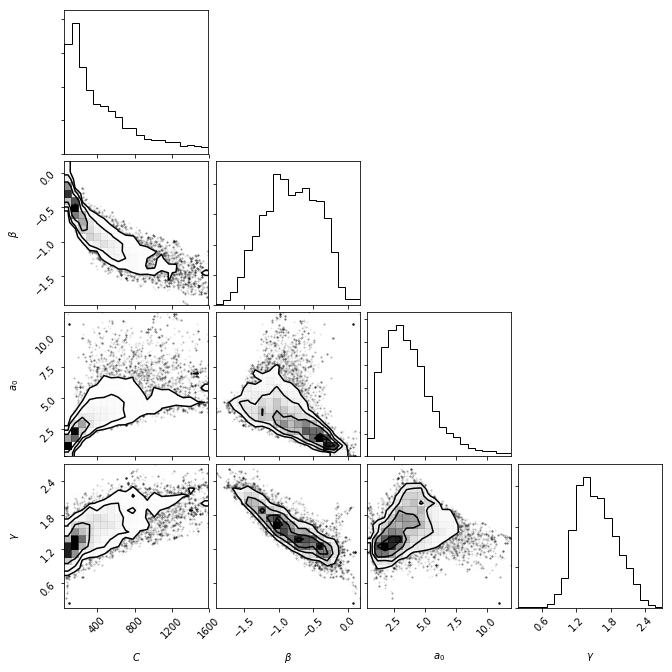

In [29]:
fig = corner.corner(broken.chains[5000:], labels = [r'$C$', r'$\beta$', r'$a_0$', r'$\gamma$'], 
                    showtitles=True)

In [19]:
broken_chains = pd.read_csv('powerlaw_chains.csv')[['C', 'beta', 'a0', 'gamma']]

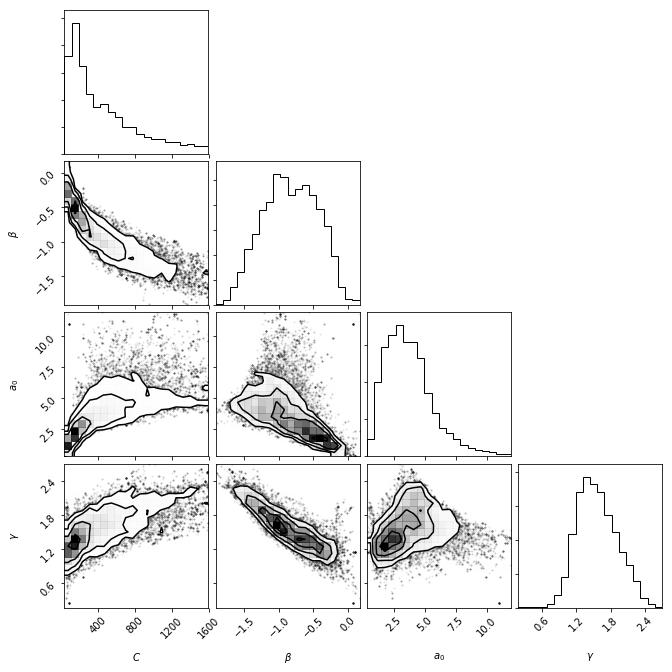

In [21]:
fig = corner.corner(broken_chains, labels = [r'$C$', r'$\beta$', r'$a_0$', r'$\gamma$'], 
                    showtitles=True)
fig.savefig('plots/corner_broken_powerlaw.pdf', bbox_inches='tight')

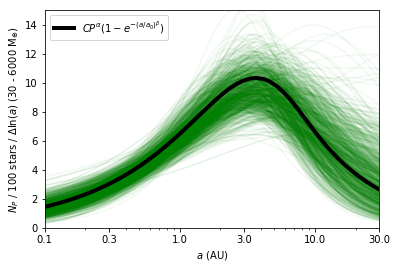

In [28]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
#ax.set_yscale('log')
#ax.set_yticks((1, 3, 10))
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

ax.set_xlim([0.1, 30])
ax.set_ylim([0, 15])

axes = np.logspace(-1, np.log10(30), num=50)
for i in np.arange(1000):
    # broken.chains[np.random.randint(0, len(broken.chains)), :]
    sample = broken_chains.iloc[np.random.randint(0, len(broken_chains))].values
    ax.plot(axes, (100/719)*occbroken(axes, sample), alpha=0.05, color='green', label='__nolegend__')
ax.plot(axes, (100/719)*occbroken(axes, np.median(broken_chains, axis=0)), \
        color='black', lw=4, label=r'$C P^{\alpha}(1 - e^{-(a/a_0)^{\beta}})$')
ax.legend()
fig.savefig('plots/broken_powerlaw_solo.pdf', bbox_inches='tight')

In [60]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins)
hierarchical_one.max_like()

In [68]:
hierarchical_one.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [45:39<00:00,  2.74s/it]


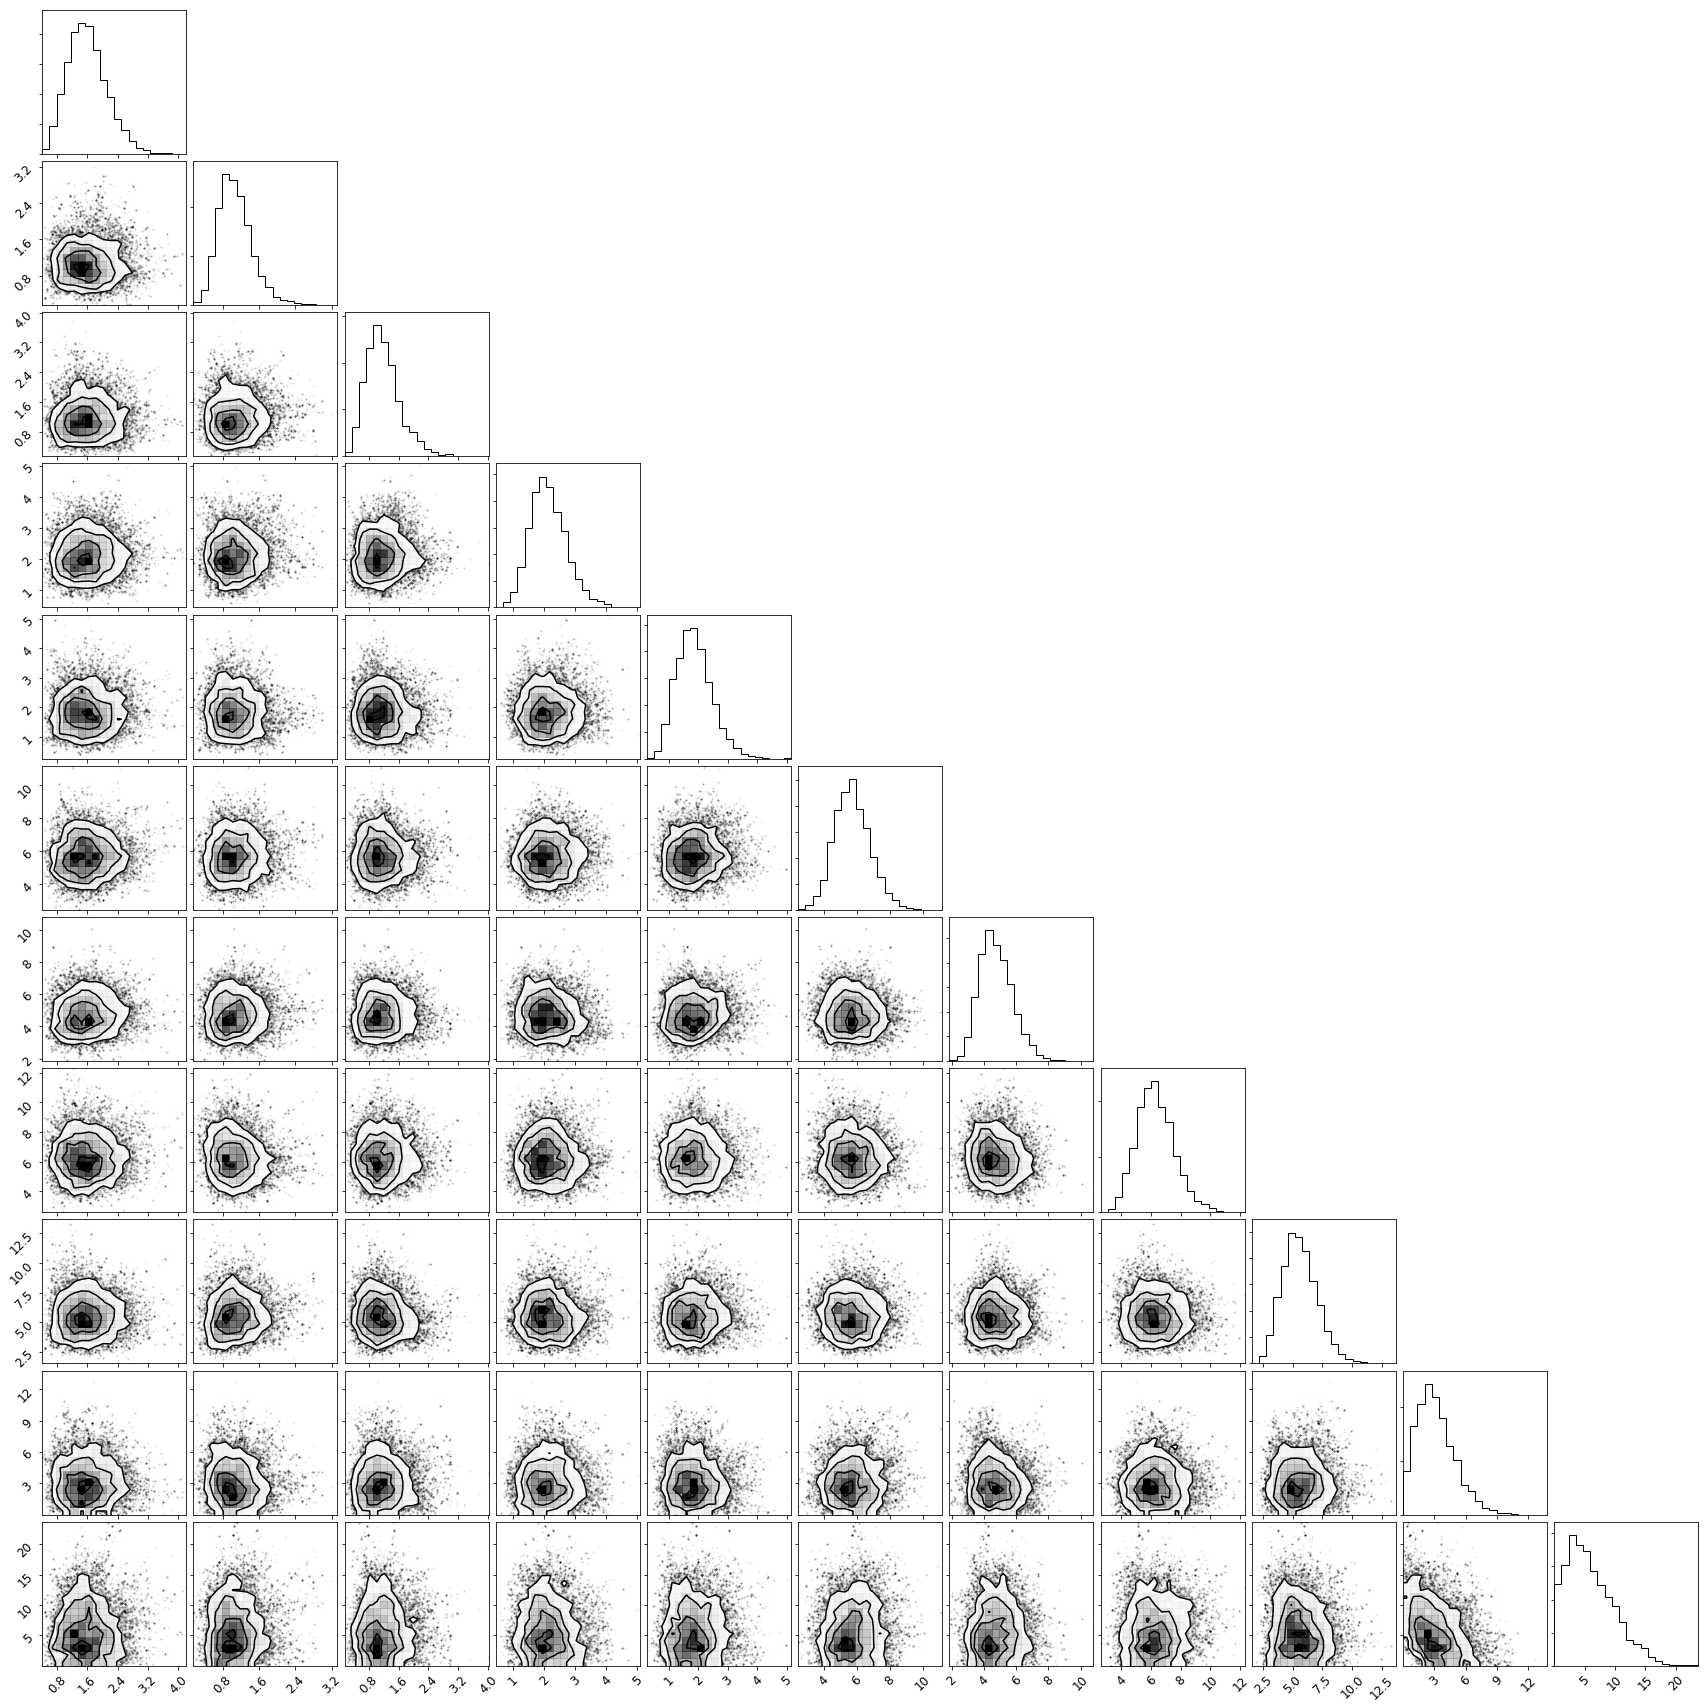

In [73]:
fig = corner.corner(hierarchical_one.chains[10000:]*hierarchical_one.bin_areas[0][0]*(100/719))
fig.savefig('corner_11x1_1014.pdf')

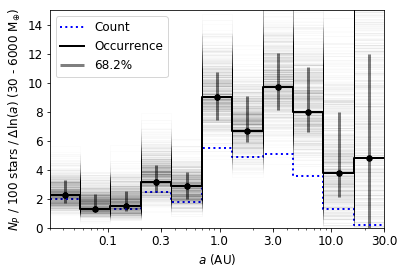

In [64]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x1_1014.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(hierarchical_one.nbins):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_one.nbins):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_one.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_one.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_one.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)/binwidth
a_159 = np.array(a_159)/binwidth
a_841 = np.array(a_841)/binwidth
a_682 = np.array(a_682)/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
#ax.set_ylabel(r'Planets per 100 stars (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

ax.set_xlim([np.exp(hierarchical_one.lna_edges[0]), np.exp(hierarchical_one.lna_edges[-1])])
#ax.set_ylim([0, 10])
ax.set_ylim([0, 15])
lnaw = hierarchical_one.lna_edges[1] - hierarchical_one.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_one.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_one.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_one.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')

for i in np.arange(1000):
    ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
            color='black', lw=1, alpha=0.01, label='_nolegend_')
 
ax.legend(loc=2) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x1_1014_fancy_mode.pdf', bbox_inches='tight')

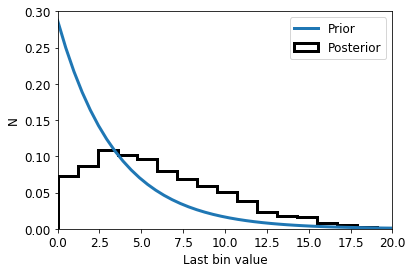

In [180]:
fig, ax = plt.subplots()

factor = hierarchical_one.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_one.ceiling*factor, num=50)

ax.plot(prior_grid, (hierarchical_one.Qints[-1]) * \
             np.exp(-hierarchical_one.Qints[-1]*prior_grid), lw=3, label='Prior')
ax.hist(factor*chains_db['gamma10'][1000:], bins=20, density=True, fill=False, 
        histtype='step', color='black', lw=3, label='Posterior')

ax.set_xlim([0, 20])
ax.set_ylim([0, 0.3])
ax.set_xlabel('Last bin value')
ax.set_ylabel('N')

ax.legend()
fig.savefig('last_bin_and_prior.png', dpi=1000, bbox_inches='tight')

NameError: name 'broken' is not defined

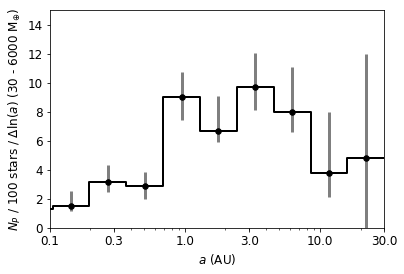

In [61]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x1_1014.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(hierarchical_one.nbins):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_one.nbins):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_one.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_one.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_one.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)/binwidth
a_159 = np.array(a_159)/binwidth
a_841 = np.array(a_841)/binwidth
a_682 = np.array(a_682)/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
#ax.set_ylabel(r'Planets per 100 stars (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

#ax.set_xlim([np.exp(hierarchical_one.lna_edges[0]), np.exp(hierarchical_one.lna_edges[-1])])
ax.set_xlim([0.1, np.exp(hierarchical_one.lna_edges[-1])])
#ax.set_ylim([0, 10])
ax.set_ylim([0, 15])
lnaw = hierarchical_one.lna_edges[1] - hierarchical_one.lna_edges[0]

# Plot just-counting, no-completeness histogram.
#ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
#        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_one.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_one.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='_nolegend_')#label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_one.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Nonparametric')

# Broken power law comparison.
#axes = np.logspace(-1, np.log10(30), num=50)
axes = np.logspace(np.log10(np.exp(hierarchical_one.lna_edges[0])), np.log10(30), num=1000)
for i in np.arange(1000):
    ax.plot(axes, (100/719)*occbroken(axes, broken.chains[np.random.randint(0, 10000), :]), 
            alpha=0.04, color='green', label='_nolegend_')
ax.plot(axes, (100/719)*occbroken(axes, np.median(broken.chains, axis=0)), 
        color='black', lw=2, ls='--', label='Broken power law') 
ax.legend(loc=2) 

#fig.savefig('hist_11x1_1014_hierarchy_and_broken.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x1_1014_hierarchy_and_broken.pdf', bbox_inches='tight')

## Redo occurrence results with 2 Msini bins per semi-major axis bin.

In [15]:
twobins = lngrid(0.03, 30., 30., 6000, 11, 2) 
hierarchical_two = Hierarchy(samples_all, completey_all, bins=twobins)
hierarchical_two.max_like()

In [27]:
hierarchical_two.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [1:23:54<00:00,  5.03s/it]


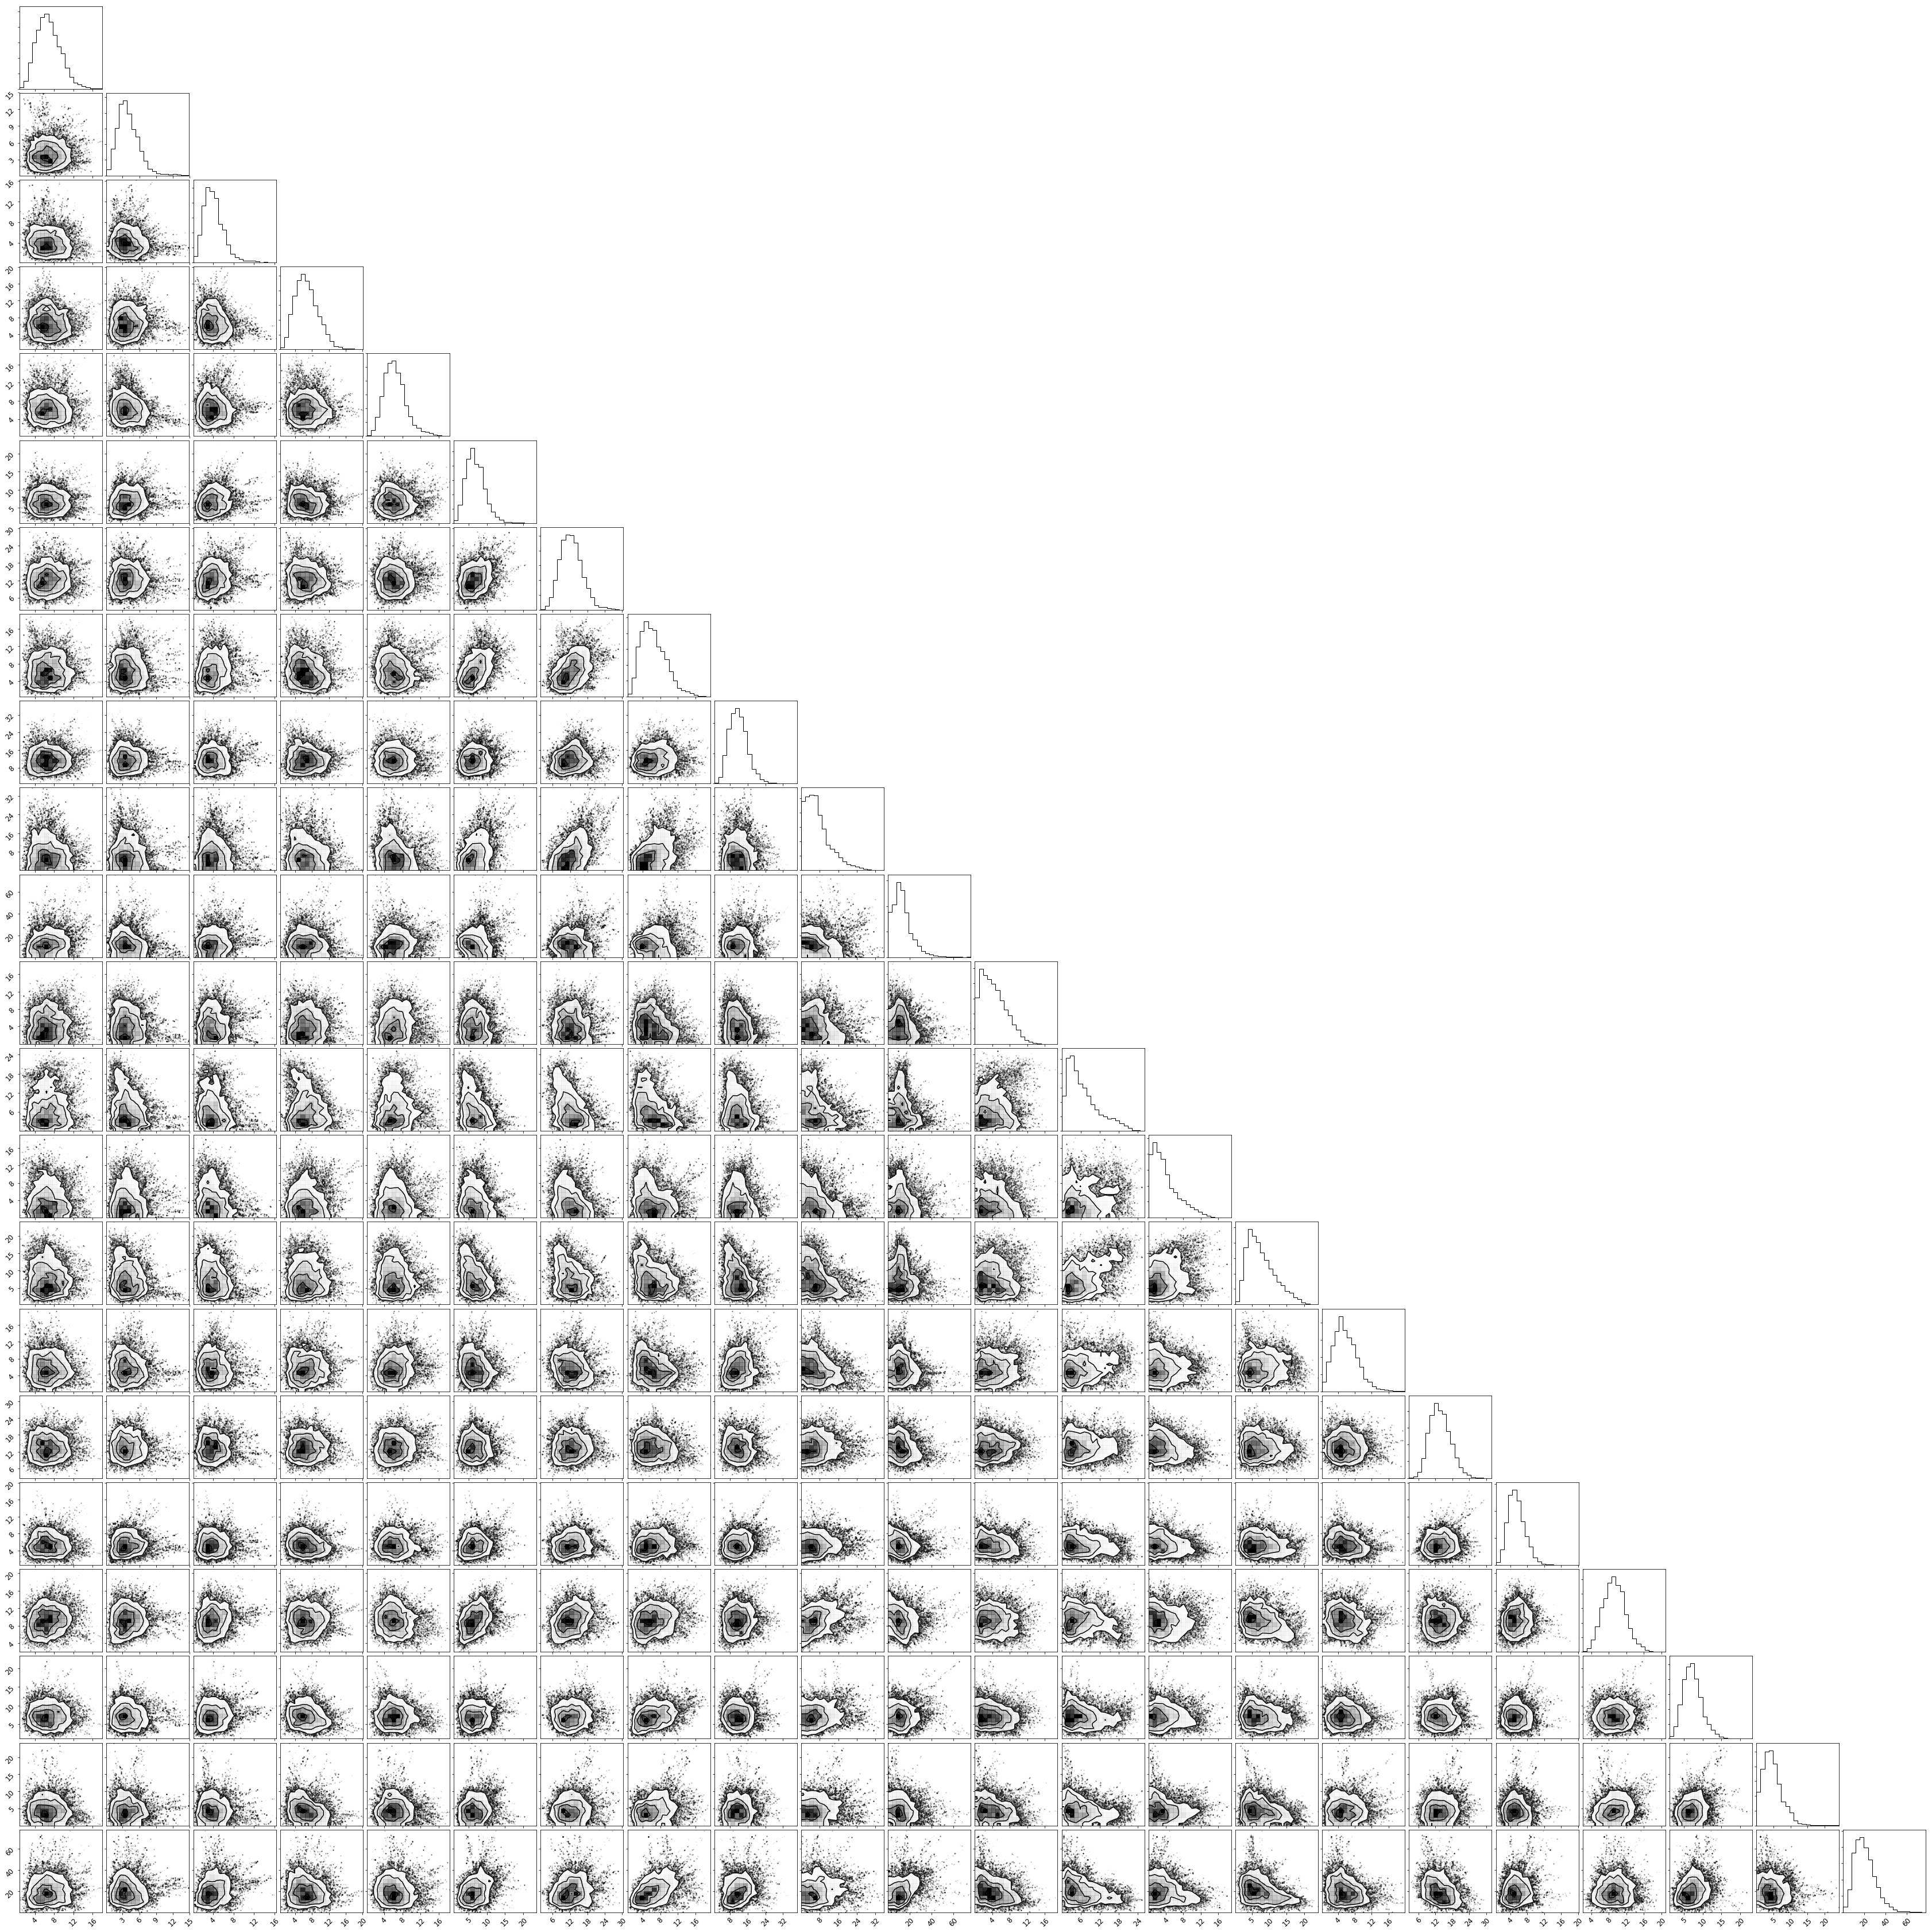

In [52]:
fig = corner.corner(hierarchical_two.chains[10000:])#*hierarchical_two.bin_areas[0][0]*(100/719))
fig.savefig('corner_11x2_1026_full.pdf')

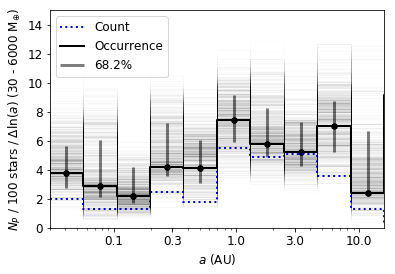

In [58]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x2_1026.csv')

binwidth = twobins[0][0][1] - twobins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(11):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(11):
    stacked_bin = np.array([chains_db['gamma{}'.format(n)]]) + np.array([chains_db['gamma{}'.format(n+11)]])
    a_chains = np.append(a_chains, stacked_bin, axis=0)
a_chains *= hierarchical_two.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []
for n in np.arange(11):
    chains = a_chains[n]
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)
a_159 = np.array(a_159)
a_841 = np.array(a_841)
a_682 = np.array(a_682)

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

ax.set_xlim([np.exp(hierarchical_two.lna_edges[0]), np.exp(hierarchical_two.lna_edges[-2])])
ax.set_ylim([0, 15])
lnaw = hierarchical_two.lna_edges[1] - hierarchical_two.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_two.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_two.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_two.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_two.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_two.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_two.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_two.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')
#'''
for i in np.arange(1000):
    ax.step(np.insert(np.exp(hierarchical_two.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_two.lna_edges[0])), 
            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
            color='black', lw=1, alpha=0.01, label='_nolegend_')
#'''  
ax.legend(loc=2) 

#fig.savefig('hist_11x2_1026_fancy_mode.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x2_1026_fancy_mode.pdf', bbox_inches='tight')

### 11X2 results seem off. Or, they're just the result of a small number of planets per bin.

In [31]:
#recoveries_planets = pd.read_csv('recoveries_planets_earth.csv')
#completey_planets  = Completeness(recoveries_planets)
#completey_planets.completeness_grid([0.01, 40], [2, 9000])

recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
completey_all.completeness_grid([0.01, 40], [2, 9000])

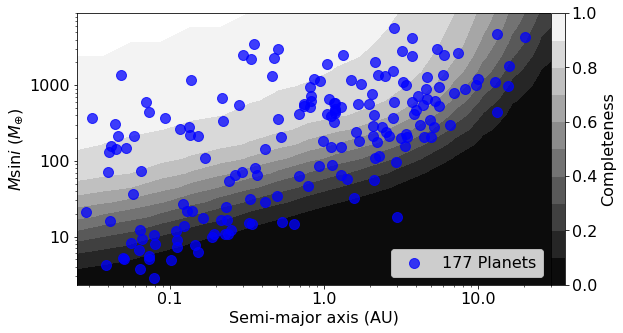

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_all.grid[0], completey_all.grid[1],
                 completey_all.grid[2], 10, cmap=plt.cm.gray)

matplotlib.rcParams.update({'font.size': 18})
ax.scatter(planets.axis, 317.8*planets.mass, c='b', s=100, alpha=0.75, 
           label='{} Planets'.format(len(planets)))

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_contours.pdf', bbox_inches='tight')

In [ ]:
with open('names_all.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(specmatch.name):
        writer.writerow([val])

with open('names_planets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(planets.hostname):
        writer.writerow([val])
        
with open('names_small.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(supers.hostname):
        writer.writerow([val])
        
with open('names_outer.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(all_outers.hostname):
        writer.writerow([val])
        
with open('names_small_and_outer.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(outers.hostname):
        writer.writerow([val])